# Programming Assignment 3
* CSCI-4930/5930 ML Spring 2019
* Author: Shreya Dubey 

# k nearest neighbor classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
from sklearn import metrics
sns.set()
from sklearn.model_selection import train_test_split
import warnings
import math
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
#Reading the csv file
X = pd.read_csv("Set-A.X.csv")
Y = pd.read_csv("Set-A.y.csv")

In [3]:
#Reading the B data set csv file
X_B = pd.read_csv("Set-B.X.csv")
Y_B = pd.read_csv("Set-B.y.csv")

In [4]:
# Handling missing values
m = X['domain1']
most_frequent = pd.get_dummies(m).sum().sort_values(ascending=False).index[0] 
def replace_most_frequent(x):
    if pd.isnull(x):
        return most_frequent
    else:
        return x
new_m = m.map(replace_most_frequent)
X['domain1'] = new_m
#print("new Value = ",X.iloc[70382]['domain1'])

# Handling the missing values in B data set
m = X_B['state1']
most_frequent = pd.get_dummies(m).sum().sort_values(ascending=False).index[0] 
def replace_most_frequent(x):
    if pd.isnull(x):
        return most_frequent
    else:
        return x
new_m = m.map(replace_most_frequent)
X_B['state1'] = new_m
#print("new Value = ",X_B.iloc[70382]['domain1'])

In [5]:
# Changing categorical value to numerical value
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df_train_dum = X['state1']
df_train_dum_encoded = encoder.fit_transform(df_train_dum)

df_train_dum1 = X['domain1']
df_train_dum1_encoded = encoder.fit_transform(df_train_dum1)

X['state1'] = df_train_dum_encoded
X['domain1'] = df_train_dum1_encoded

df_train_B_dum = X_B['state1']
df_train_B_dum_encoded = encoder.fit_transform(df_train_B_dum)

df_train_B_dum1 = X_B['custAttr2']
df_train_B_dum1_encoded = encoder.fit_transform(df_train_B_dum1)

X_B['state1'] = df_train_B_dum_encoded
X_B['custAttr2'] = df_train_B_dum1_encoded

In [6]:
# Changing to numpy 
X = X.values
X_new = X[0:94681,:]

X_B = X_B.values
X_B_new = X_B[0:99999,:]

In [7]:
# Joining the X and Y into one data set
X_new = np.append(X_new,Y,axis=1)

X_B_new = np.append(X_B_new,Y_B,axis=1)

Task 3.5 I have created a less skewed data set by lowering the value of negative samples

In [8]:
# Creating a less skewed data set
m = 0
n = 0
X_train_whole = np.empty((20940,20))
X_not_fraud = np.empty((92587,20))
for a in X_new:
    if(a[-1]==1):
        X_train_whole[m,:] = a
        m = m+1
    else:
        X_not_fraud[n,:] = a
        n = n+1

for j in range (18846):
    X_train_whole[m+j,:] = X_not_fraud[j,:]
    
# Creating a less skewed data set for B data set
m1 = 0
n1 = 0
X_train_B_whole = np.empty((26540,20))
X_not_B_fraud = np.empty((97345,20))
for a in X_B_new:
    if(a[-1]==1):
        X_train_B_whole[m1,:] = a
        m1 = m1+1
    else:
        X_not_B_fraud[n1,:] = a
        n1 = n1+1

for j in range (23886):
    X_train_B_whole[m1+j,:] = X_not_B_fraud[j,:]

In [9]:
# Splitting the data into training and testing data

#train_set, test_set = train_test_split(X_new, test_size=0.20)
train_set, test_set = train_test_split(X_train_whole, test_size=0.20 )
X_train = train_set[:,0:18]
Y_train = train_set[:,19]

X_test = test_set[:,0:18]
Y_test = test_set[:,19]

Y_train.shape = (len(Y_train),1)

#train_set_B, test_set_B = train_test_split(X_B_new, test_size=0.20)
train_set_B, test_set_B = train_test_split(X_train_B_whole, test_size=0.20 )
X_train_B = train_set_B[:,0:18]
Y_train_B = train_set_B[:,19]

X_test_B = test_set_B[:,0:18]
Y_test_B = test_set_B[:,19]

Y_train_B.shape = (len(Y_train_B),1)

In [10]:
# Normalizing teh data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_B = scaler.fit_transform(X_train_B)
X_test_B = scaler.transform(X_test_B)

In [11]:
# Function to calculate distance between 2 data points
def getDistance(X,X1):
    sum = 0
    for i in range(18):
        z = X[0,i]-X1[0,i]
        z = z*z
        sum = sum +z
    return math.sqrt(sum)

In [12]:
# Function to get the nearest data point
def getNearest(num, dist):
    ans = np.empty(num)
    for j in range (num):
        result = np.where(dist == np.amin(dist))
        ans[j] = result[0][0]
        dist = np.delete(dist,result)
    return ans

In [13]:
# Function to get vote
def getVote(N,X):
    value =0
    for i in N:
        value = value + X[int(i)][0]
    if(value>len(N)/2):
        return 1
    else:
        return 0

In [14]:
# Function for kNN classification
def kNNClassify(X_train,X_test,Y_train,k):
    Y_learned = np.empty(len(X_test)) 
    for a in range (len(X_test)):
        distance = np.empty(len(X_train))
        x_test_one = X_test[a,:]
        x_test_one.shape = (1,18)
        for i in range (len(X_train)):
            x_train_one = X_train[i,:]
            x_train_one.shape = (1,18)
            distance[i] = getDistance(x_train_one,x_test_one)
        index = getNearest(k,distance)
        Y_learned[a] = getVote(index,Y_train)
    return Y_learned

In [16]:
def getCost(tp,tn,fp,fn):
    Cost2 = (tp*(-1))+(tn*(0))+(fp*100)+(fn*(1))
    Cost1 = (tp*(-1))+(tn*(0))+(fp*1)+(fn*(100))
    return Cost1,Cost2

In [17]:
# Function to get results
def getResult(Y_test,learned_Y,y_score):
    confusion_matrix = metrics.confusion_matrix(Y_test,learned_Y)
    tn, fp, fn, tp = metrics.confusion_matrix(Y_test,learned_Y).ravel()
    accuracy = metrics.accuracy_score(Y_test,learned_Y)
    precision = metrics.precision_score(Y_test,learned_Y) 
    recall = metrics.recall_score(Y_test,learned_Y)
    fscore = metrics.f1_score(Y_test,learned_Y)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,y_score) 
    auc = metrics.roc_auc_score(Y_test,y_score)
    
    print("KNN Classifier")
    print("confusion matrix = ",confusion_matrix)
    print("tp = ",tp,"fp = ",fp,"fn = ",fn,"tn = ",tn)
    print("accuracy score  = ",accuracy)
    print("precision = ",precision)
    print("recall = ",recall)
    print("F1-score = ",fscore)
    print("auc = ",auc)
    cost1,cost2 = getCost(tp,tn,fp,fn)
    print("Cost for less false negative = ",cost1)
    print("Cost for less false positive = ",cost2)
    
    plt.plot(fpr,tpr)
    plt.plot(fpr,fpr,linestyle = 'dashed', color = 'olive')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

I have selected this hyperparameter after running cross validation on different values of K

In [18]:
# Setting the value of K
k = 5

Task 3.1 performing 10 fold cross validation

confusion matrix =  [[1515    9]
 [ 148    4]]
tp =  4 fp =  9 fn =  148 tn =  1515
accuracy score  =  0.9063245823389021
precision =  0.3076923076923077
recall =  0.02631578947368421
F1-score =  0.048484848484848485
auc =  0.5102051388313303


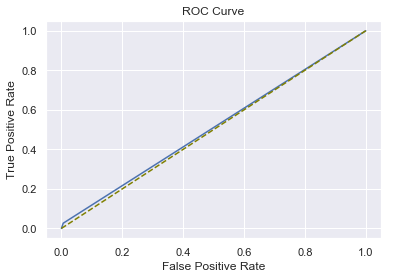

confusion matrix =  [[1499   14]
 [ 152   11]]
tp =  11 fp =  14 fn =  152 tn =  1499
accuracy score  =  0.9009546539379475
precision =  0.44
recall =  0.06748466257668712
F1-score =  0.11702127659574468
auc =  0.5291157615593284


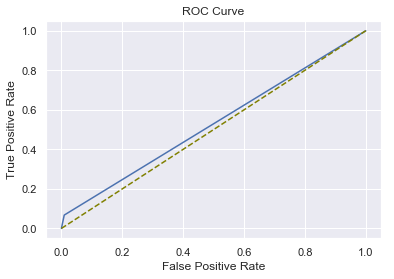

confusion matrix =  [[1493    7]
 [ 171    4]]
tp =  4 fp =  7 fn =  171 tn =  1493
accuracy score  =  0.8937313432835821
precision =  0.36363636363636365
recall =  0.022857142857142857
F1-score =  0.04301075268817204
auc =  0.5090952380952382


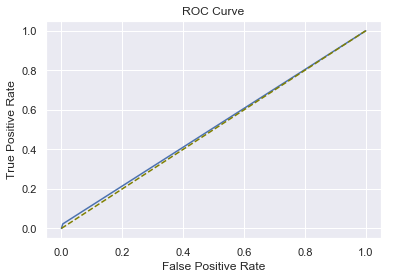

confusion matrix =  [[1493    6]
 [ 169    7]]
tp =  7 fp =  6 fn =  169 tn =  1493
accuracy score  =  0.8955223880597015
precision =  0.5384615384615384
recall =  0.03977272727272727
F1-score =  0.07407407407407407
auc =  0.5178850294135484


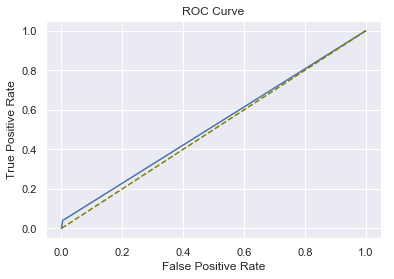

confusion matrix =  [[1506    8]
 [ 150   11]]
tp =  11 fp =  8 fn =  150 tn =  1506
accuracy score  =  0.9056716417910448
precision =  0.5789473684210527
recall =  0.06832298136645963
F1-score =  0.12222222222222222
auc =  0.5315194827572061


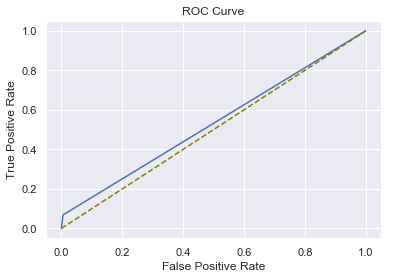

confusion matrix =  [[1495    8]
 [ 164    8]]
tp =  8 fp =  8 fn =  164 tn =  1495
accuracy score  =  0.8973134328358209
precision =  0.5
recall =  0.046511627906976744
F1-score =  0.0851063829787234
auc =  0.5205944699747791


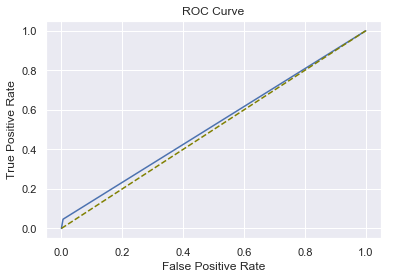

confusion matrix =  [[1507    8]
 [ 155    5]]
tp =  5 fp =  8 fn =  155 tn =  1507
accuracy score  =  0.902686567164179
precision =  0.38461538461538464
recall =  0.03125
F1-score =  0.057803468208092484
auc =  0.5129847359735974


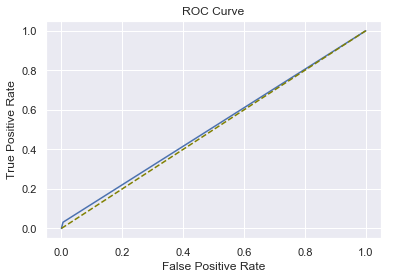

confusion matrix =  [[1495    6]
 [ 163   11]]
tp =  11 fp =  6 fn =  163 tn =  1495
accuracy score  =  0.8991044776119403
precision =  0.6470588235294118
recall =  0.06321839080459771
F1-score =  0.11518324607329844
auc =  0.5296105278473355


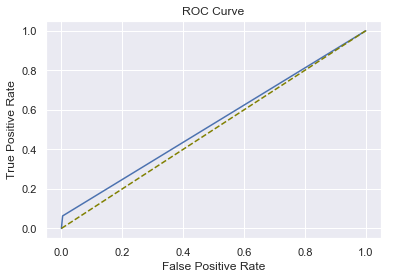

confusion matrix =  [[1508    3]
 [ 152   12]]
tp =  12 fp =  3 fn =  152 tn =  1508
accuracy score  =  0.9074626865671642
precision =  0.8
recall =  0.07317073170731707
F1-score =  0.1340782122905028
auc =  0.5355926458007135


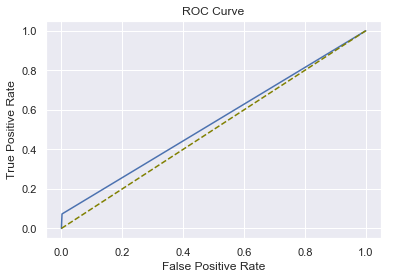

confusion matrix =  [[1467   16]
 [ 181   11]]
tp =  11 fp =  16 fn =  181 tn =  1467
accuracy score  =  0.8823880597014926
precision =  0.4074074074074074
recall =  0.057291666666666664
F1-score =  0.10045662100456619
auc =  0.5232513626657677


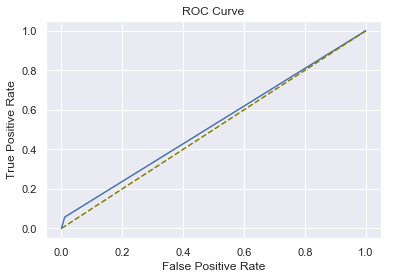

confusion matrix =  [[1907    4]
 [ 189   24]]
tp =  24 fp =  4 fn =  189 tn =  1907
accuracy score  =  0.9091337099811676
precision =  0.8571428571428571
recall =  0.11267605633802817
F1-score =  0.19917012448132781
auc =  0.5552914556938703


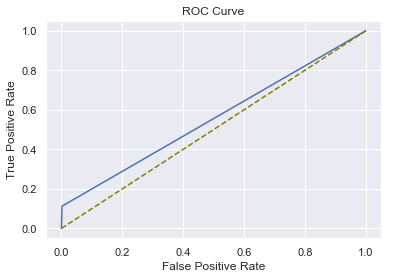

confusion matrix =  [[1929    3]
 [ 162   30]]
tp =  30 fp =  3 fn =  162 tn =  1929
accuracy score  =  0.922316384180791
precision =  0.9090909090909091
recall =  0.15625
F1-score =  0.2666666666666666
auc =  0.5773486024844721


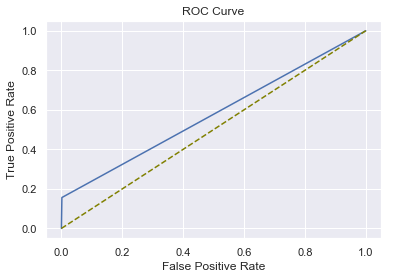

confusion matrix =  [[1893    8]
 [ 195   27]]
tp =  27 fp =  8 fn =  195 tn =  1893
accuracy score  =  0.9043805934997645
precision =  0.7714285714285715
recall =  0.12162162162162163
F1-score =  0.21011673151750976
auc =  0.5587066551032884


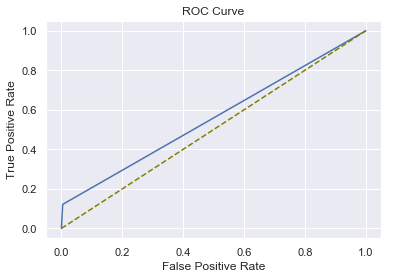

confusion matrix =  [[1923    5]
 [ 165   30]]
tp =  30 fp =  5 fn =  165 tn =  1923
accuracy score  =  0.9199246349505417
precision =  0.8571428571428571
recall =  0.15384615384615385
F1-score =  0.2608695652173913
auc =  0.5756263964251516


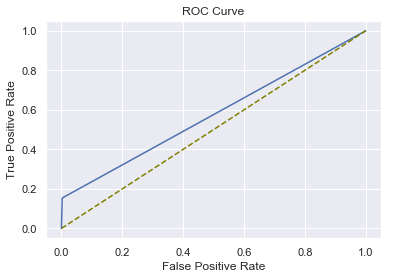

confusion matrix =  [[1901    8]
 [ 184   30]]
tp =  30 fp =  8 fn =  184 tn =  1901
accuracy score  =  0.9095619406500236
precision =  0.7894736842105263
recall =  0.14018691588785046
F1-score =  0.23809523809523805
auc =  0.5679981200706931


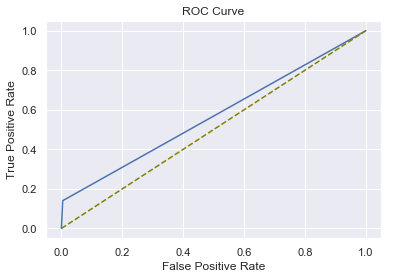

confusion matrix =  [[1897    5]
 [ 198   23]]
tp =  23 fp =  5 fn =  198 tn =  1897
accuracy score  =  0.9043805934997645
precision =  0.8214285714285714
recall =  0.10407239819004525
F1-score =  0.1847389558232932
auc =  0.5507217932064843


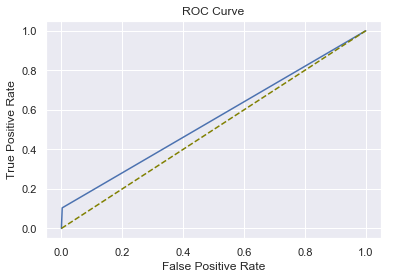

confusion matrix =  [[1899   14]
 [ 190   20]]
tp =  20 fp =  14 fn =  190 tn =  1899
accuracy score  =  0.90390956194065
precision =  0.5882352941176471
recall =  0.09523809523809523
F1-score =  0.1639344262295082
auc =  0.5439598735469097


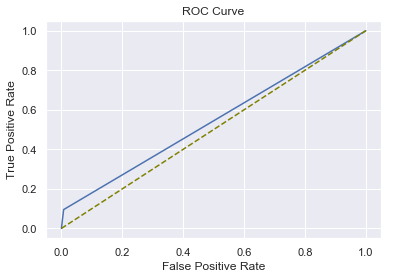

confusion matrix =  [[1911    7]
 [ 183   22]]
tp =  22 fp =  7 fn =  183 tn =  1911
accuracy score  =  0.9105040037682525
precision =  0.7586206896551724
recall =  0.1073170731707317
F1-score =  0.18803418803418803
auc =  0.5518337190671176


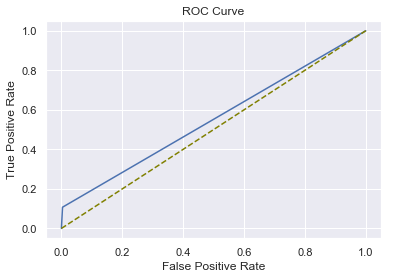

confusion matrix =  [[1893    3]
 [ 201   26]]
tp =  26 fp =  3 fn =  201 tn =  1893
accuracy score  =  0.90390956194065
precision =  0.896551724137931
recall =  0.1145374449339207
F1-score =  0.203125
auc =  0.556477583226454


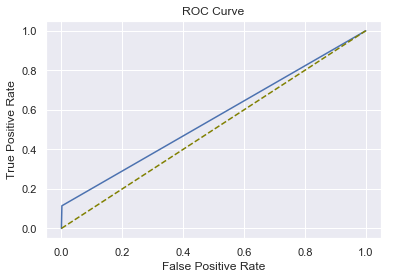

confusion matrix =  [[1913    7]
 [ 178   25]]
tp =  25 fp =  7 fn =  178 tn =  1913
accuracy score  =  0.9128591615638247
precision =  0.78125
recall =  0.12315270935960591
F1-score =  0.2127659574468085
auc =  0.5597534380131363


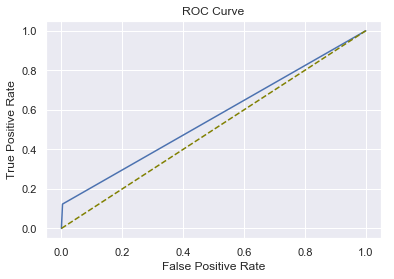

In [17]:
# Performing 10 fold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10)

# for data set A
kf.get_n_splits(X_train)

for train_index, test_index in kf.split(X_train):
    X_train1, X_test1 = X_train[train_index], X_train[test_index]
    y_train1, y_test1 = Y_train[train_index], Y_train[test_index]
    learned_Y = kNNClassify(X_train1,X_test1,y_train1,k)
    getResult(y_test1,learned_Y,learned_Y)

# for data set B
kf.get_n_splits(X_train_B)

for train_index, test_index in kf.split(X_train_B):
    X_train1, X_test1 = X_train_B[train_index], X_train_B[test_index]
    y_train1, y_test1 = Y_train_B[train_index], Y_train_B[test_index]
    learned_Y = kNNClassify(X_train1,X_test1,y_train1,k)
    getResult(y_test1,learned_Y,learned_Y)

Task 3.2 Running the classifier on training data

KNN Classifier
confusion matrix =  [[15048    40]
 [ 1489   175]]
tp =  175 fp =  40 fn =  1489 tn =  15048
accuracy score  =  0.9087273161413563
precision =  0.813953488372093
recall =  0.10516826923076923
F1-score =  0.18626929217668972
auc =  0.5512585778815564
Cost for less false negative =  148765
Cost for less false positive =  5314


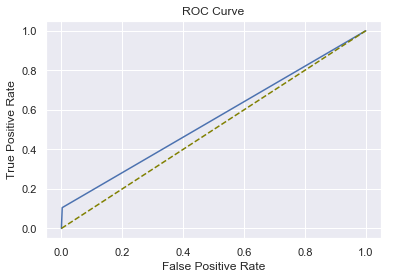

In [19]:
# Running classifier for train data A
learned_Y_train = kNNClassify(X_train,X_train,Y_train,k)
getResult(Y_train,learned_Y_train,learned_Y_train)

Task 3.3 Running the classifier on test data

KNN Classifier
confusion matrix =  [[3731   27]
 [ 415   15]]
tp =  15 fp =  27 fn =  415 tn =  3731
accuracy score  =  0.8944603629417383
precision =  0.35714285714285715
recall =  0.03488372093023256
F1-score =  0.0635593220338983
auc =  0.5138495241159945
Cost for less false negative =  41512
Cost for less false positive =  3100


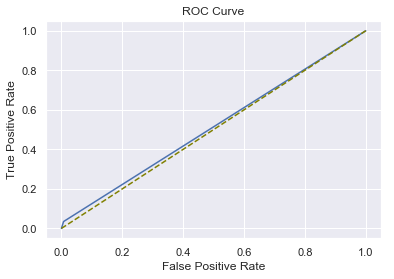

In [20]:
# Running classifier for test data A
learned_Y_test = kNNClassify(X_train,X_test,Y_train,k)
getResult(Y_test,learned_Y_test,learned_Y_test)

In [21]:
# Running classifier for train data B
learned_Y_train_B = kNNClassify(X_train_B,X_train_B,Y_train_B,k)
getResult(Y_train_B,learned_Y_train_B,learned_Y_train_B)

KeyboardInterrupt: 

In [ ]:
# Running classifier for test data B
learned_Y_test_B = kNNClassify(X_train_B,X_test_B,Y_train_B,k)
getResult(Y_test_B,learned_Y_test_B,learned_Y_test_B)

Task 3.4 The KNN classifier gives us similar results in both the cases that is train and test so that shows that there is no overfitting or underfitting happening in this classifier.